In [30]:
import numpy        as np
import numpy.random as npr
import matplotlib.pyplot as plt
import time
from bisect import bisect, bisect_left
from scipy.interpolate import interp1d, splrep, splev, UnivariateSpline, Akima1DInterpolator, PchipInterpolator, CubicSpline

from matplotlib.offsetbox import AnchoredText
import PyMieScatt as ps

import pickle

plt.style.use('ggplot')

# This notebook compares four methods to sample from the Henyey-Greenstein phase function.

- Inverse Transform Method (ILT)
- Forward Look-up Table method (FLT)
- Inverse Look-up Table method (ILT)
- Aliad method (Alias)

The goal is to compare the complexity of these methods.

In [100]:
# Generate phase function for HG function
def HG(mu, g):
    return (1-g*g)/(4*np.pi*(1+g*g-2*g*mu)**1.5)

# Normalize data to scale the output to get probability density function
# This means that the sum is equal to 1
# Data must only contain positive values (which is the case in this example)
def NormalizeData(data):
    return data / np.sum(data)# - np.min(data))

# Set  variables
g = -.2                                   #anisotropy factor (global)
intervals = 1000                            #number of theta intervals
samples = int(1e6)                         #number of Monte Carlo samples
# thetas = np.linspace(np.pi,0,intervals)  #angles
# costhetas = np.cos(thetas)                #cos(angles)

mus = np.linspace(-1, 1, intervals)  #mus determines the look-up table intervals - linear intervals
muthetas = np.arccos(mus)

phasefunction = HG(costhetas, g) 
phasefunction /= np.sum(phasefunction)  #scale to turn angles into probabilities 

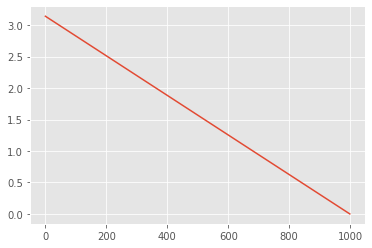

In [110]:
plt.plot(thetas)

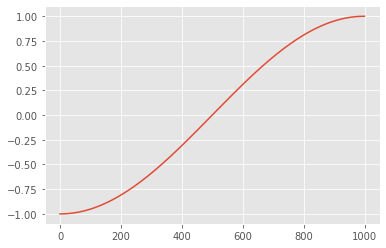

In [111]:
plt.plot(costhetas)

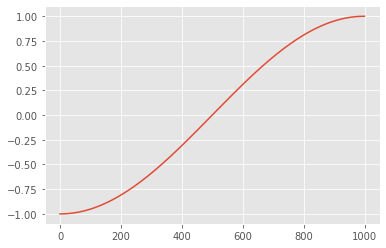

In [112]:
plt.plot(np.cos(thetas))

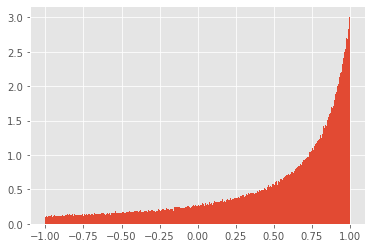

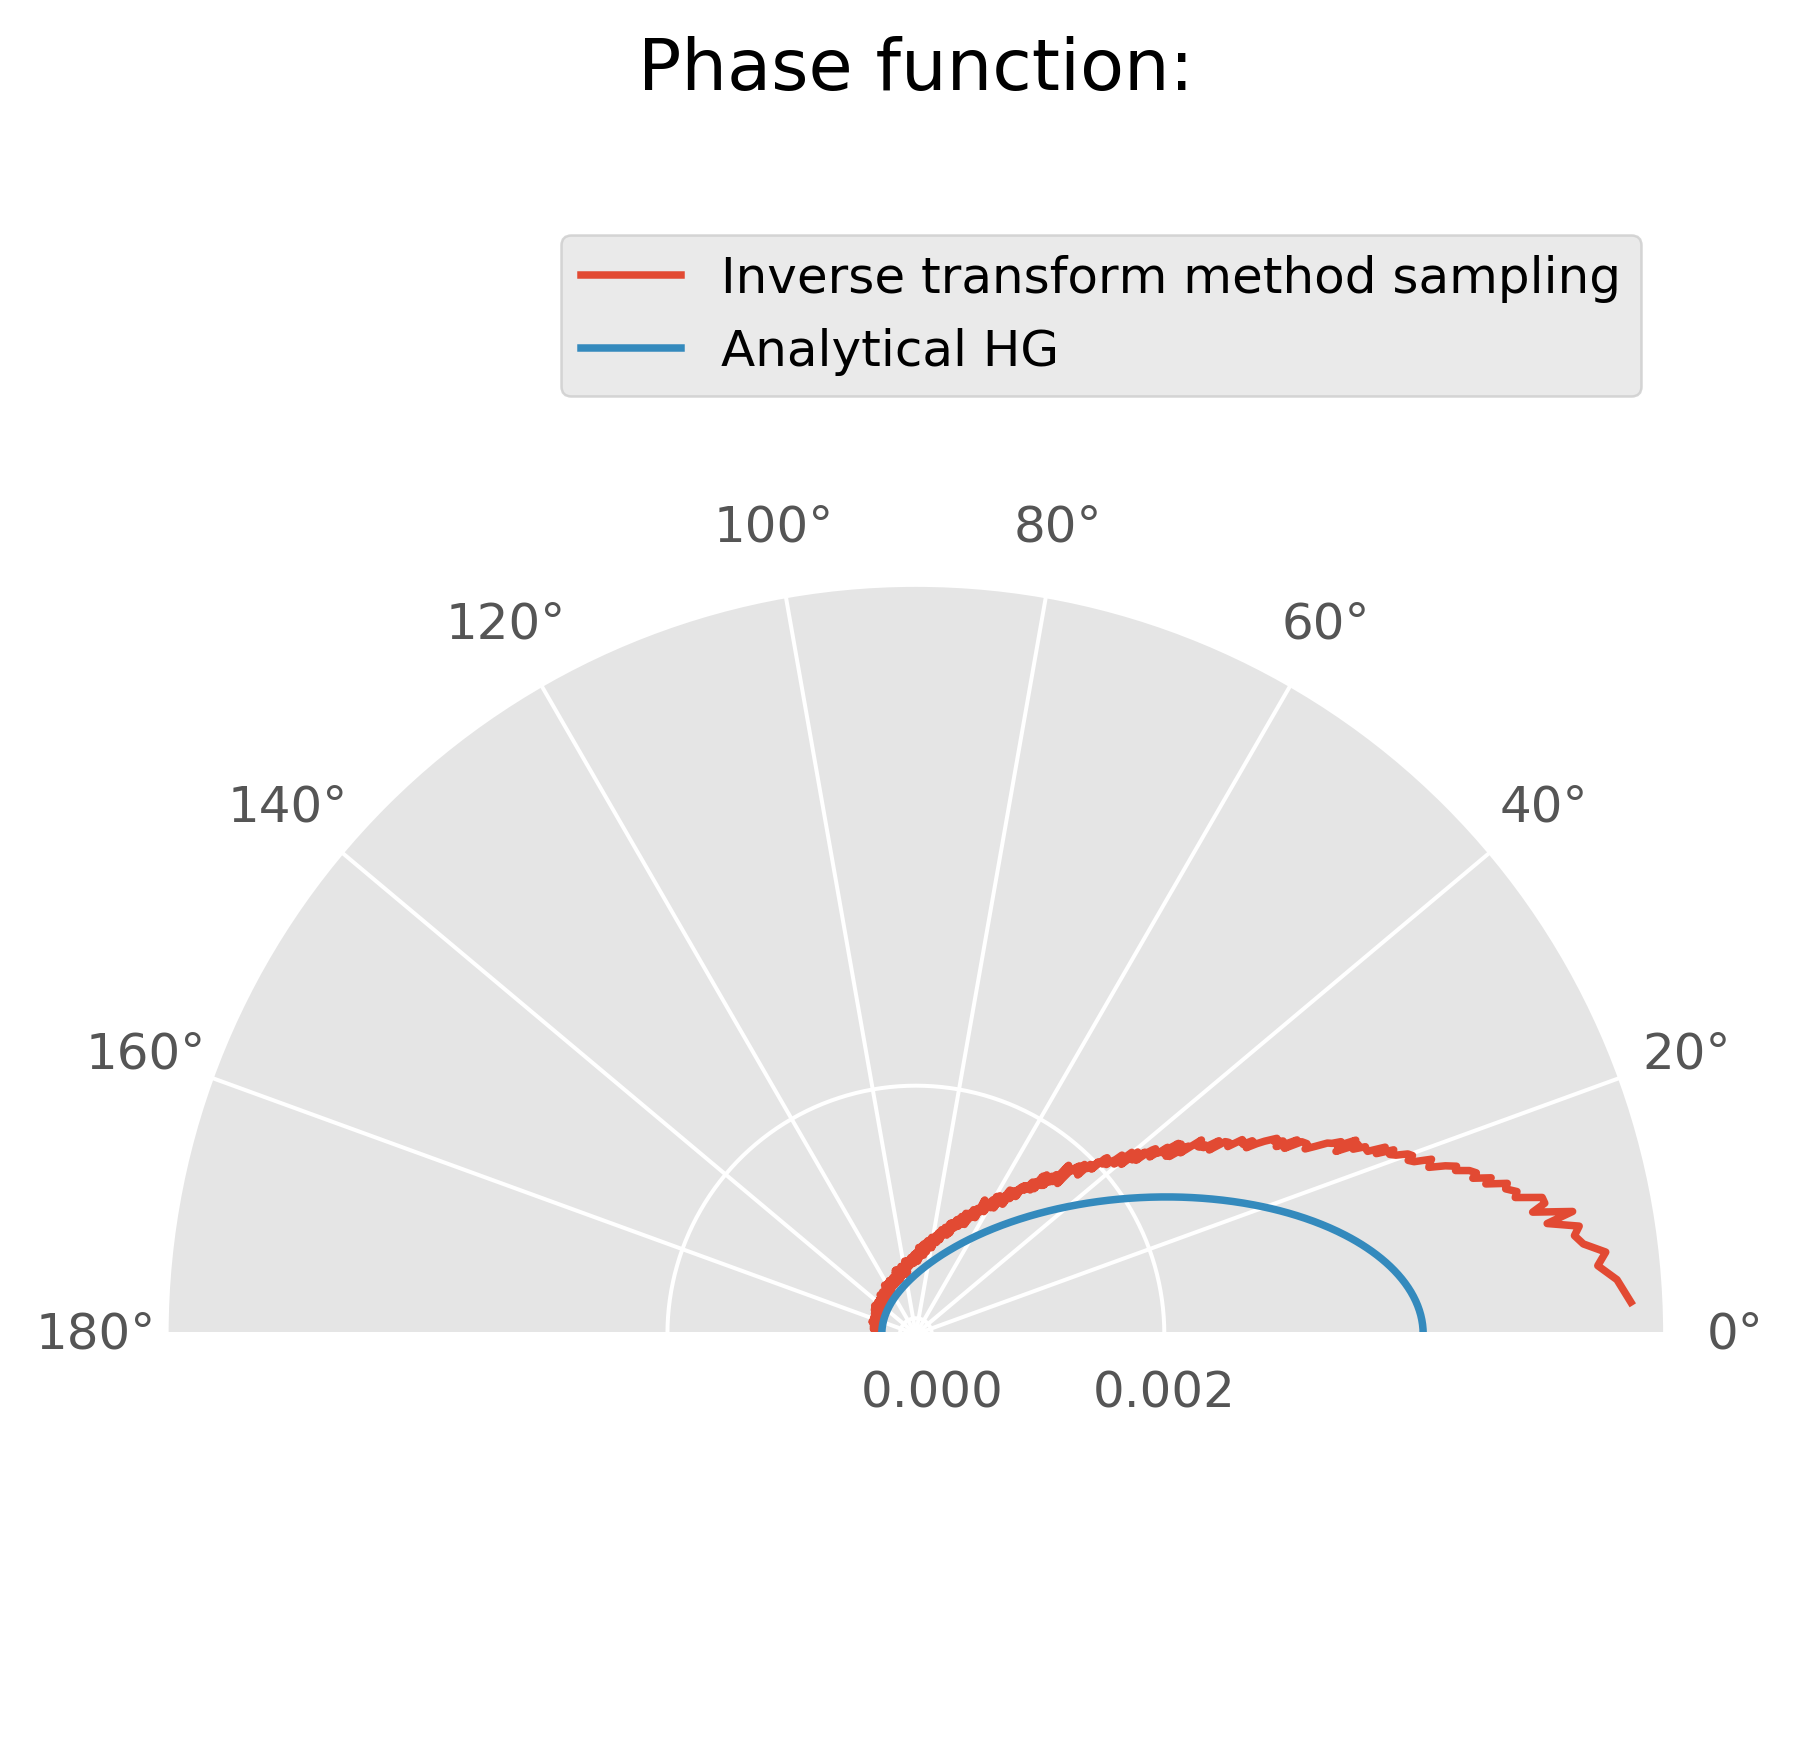

In [103]:
# Inverse transform method sampling from analytical HG

# Monte Carlo sample from CDF of HG phase function 
# If anisotropy g is , isotropic scattering: cos(theta) = 2*rand-1.
# otherwise: sample according to the Henyey-Greenstein function.
# Returns the cosine of the polar deflection angle theta.
def SampleHG(g):
    if g == 0.0:
        costh = 2 * np.random.random_sample() - 1
    else:
        temp = (1 - g * g) / (1 - g + 2 * g * np.random.random_sample())
        costh = (1 + g * g - temp * temp) / (2 * g)
        if costh < -1:
            costh = -1.0
        elif costh > 1:
            costh = 1.0
    return costh







# # Generate variates.
analyticalsampledPF = [SampleHG(g) for i in range(samples)]


# Visualize on polar plot
counts, bins, bars = plt.hist(analyticalsampledPF, bins= intervals, density=True)
x = [np.arccos((bins[i]+bins[i+1])/2) for i in range(len(bins)-1)]   #transform x-data from mu=cos(theta) to theta



# x = np.linspace(np.pi, 0, len(bins)-1)  # x-axis have to be theta values in the polar plot

# Plot both the analytical and the analytically sampled phase function
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (5,5), dpi=360)

# Output has to be scaled accordingly 
# Monte Carlo output is divided by 2 due to symmetry in positive and negative angles
ax.plot(x, NormalizeData(counts), label = 'Inverse transform method sampling')
ax.plot(thetas, NormalizeData(phasefunction), label = 'Analytical HG')



# Output has to be scaled accordingly 
# Analytical result is multiplied by 2 due to symmetry in positive and negative angles
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.set_rticks([0, np.round(np.max(NormalizeData(phasefunction)/2),3)])
ax.grid(True)
ax.set_title("Phase function:", va='bottom')
ax.set_thetamin(0)
ax.set_thetamax(180)

plt.legend()
plt.tight_layout()
plt.show()


1000


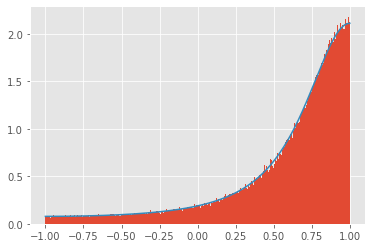

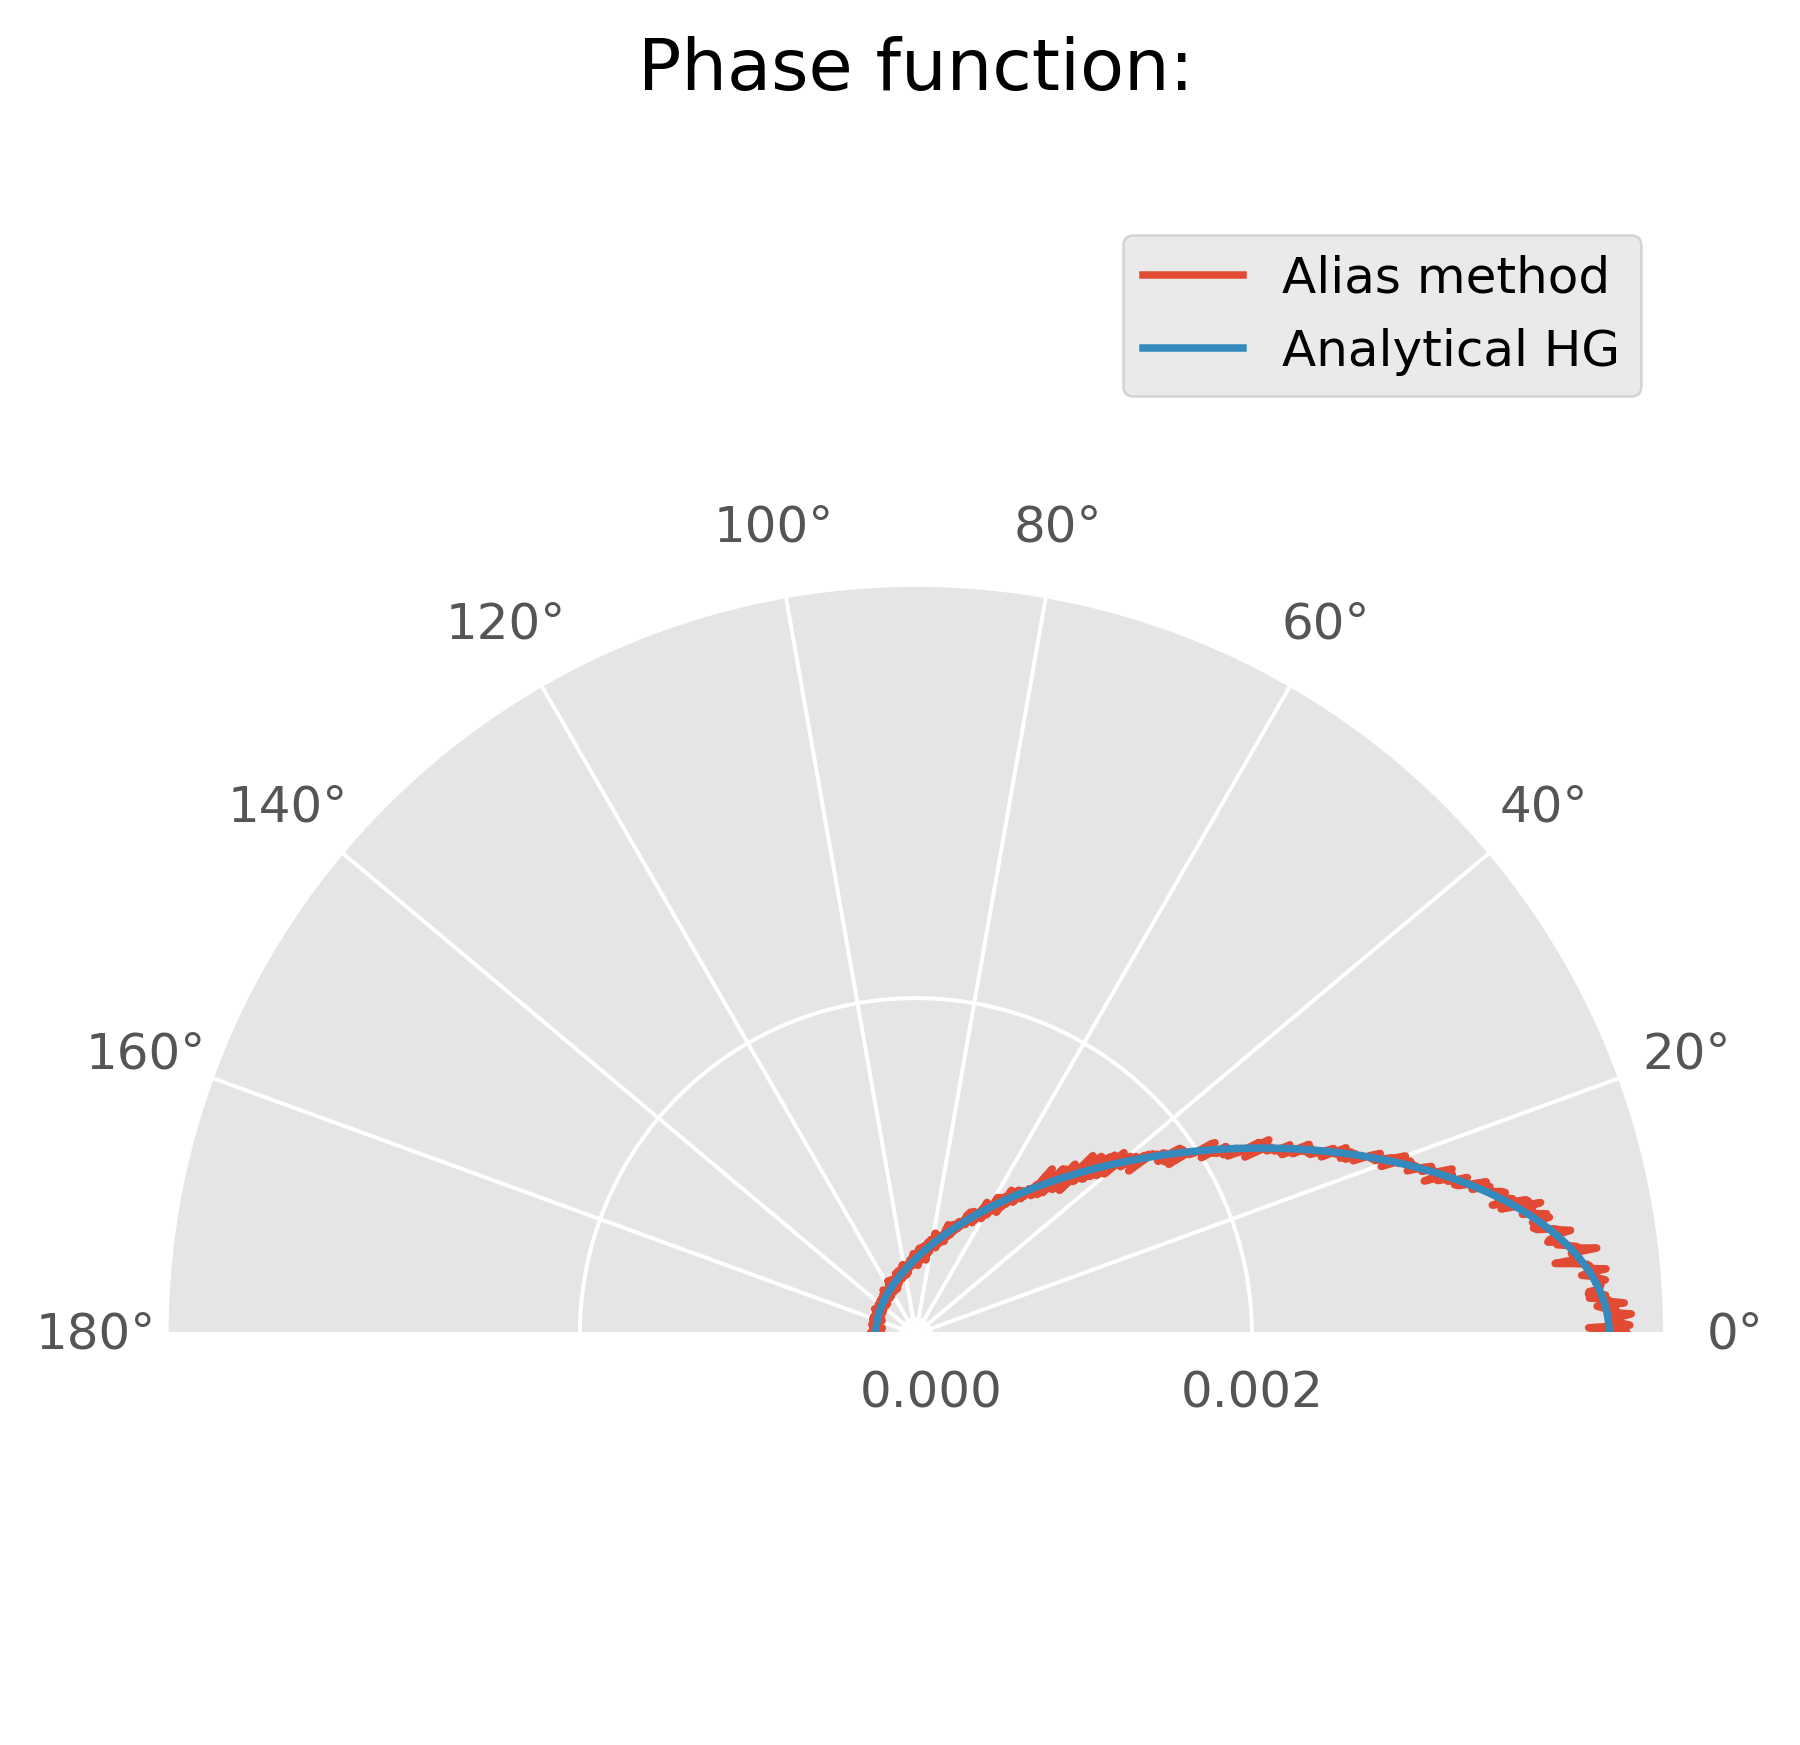

In [97]:
# Alias

def alias_setup(probs):
    K       = len(probs)
    q       = np.zeros(K)
    J       = np.zeros(K, dtype=np.int)

    # Sort the data into the outcomes with probabilities
    # that are larger and smaller than 1/K.
    smaller = []
    larger  = []
    for kk, prob in enumerate(probs):
        q[kk] = K*prob
        if q[kk] < 1.0:
            smaller.append(kk)
        else:
            larger.append(kk)

    # Loop though and create little binary mixtures that
    # appropriately allocate the larger outcomes over the
    # overall uniform mixture.
    while len(smaller) > 0 and len(larger) > 0:
        small = smaller.pop()
        large = larger.pop()

        J[small] = large
        q[large] = q[large] - (1.0 - q[small])

        if q[large] < 1.0:
            smaller.append(large)
        else:
            larger.append(large)

    return J, q

def alias_draw(J, q, costhetas):
    K  = len(J)

    zeta = np.random.random_sample()
    # Draw from the overall uniform mixture.
    kk = int(np.floor(zeta*K))

    # Draw from the binary mixture, either keeping the
    # small one, or choosing the associated larger one.
    randomvalue = np.random.random_sample()
    if randomvalue < q[kk]:
        ind = kk
    else:
        ind = J[kk]    
    
    #     #linear interpolation (try-except to include last interval)
    try:
#         print(ind)
        value = costhetas[ind] + randomvalue * (costhetas[ind+1] - costhetas[ind])
    except:
        value = -1 + 2*randomvalue

    return value

K = len(phasefunction)
print(K)
K = 100
N = 100000




# # # Construct the table.
J, q = alias_setup(phasefunction)

# # Generate variates.
aliassampledPF = [alias_draw(J, q, mus) for i in range(samples)]


# Visualize on polar plot
counts, bins, bars = plt.hist(aliassampledPF, bins= intervals, density=True)
x = [np.arccos((bins[i]+bins[i+1])/2) for i in range(len(bins)-1)]   #transform x-data from mu=cos(theta) to theta
plt.plot(mus, phasefunction*500)

# Plot both the analytical and the analytically sampled phase function
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (5,5), dpi=360)

# Output has to be scaled accordingly 
# Monte Carlo output is divided by 2 due to symmetry in positive and negative angles
ax.plot(thetas, NormalizeData(counts), label = 'Alias method')
ax.plot(thetas, NormalizeData(phasefunction), label = 'Analytical HG')



# Output has to be scaled accordingly 
# Analytical result is multiplied by 2 due to symmetry in positive and negative angles
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.set_rticks([0, np.round(np.max(NormalizeData(phasefunction)/2),3)])
ax.grid(True)
ax.set_title("Phase function:", va='bottom')
ax.set_thetamin(0)
ax.set_thetamax(180)

plt.legend()
plt.tight_layout()
plt.show()


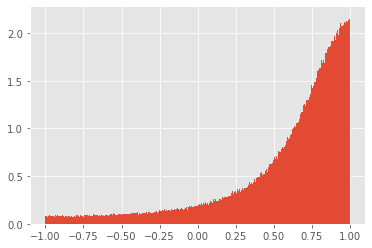

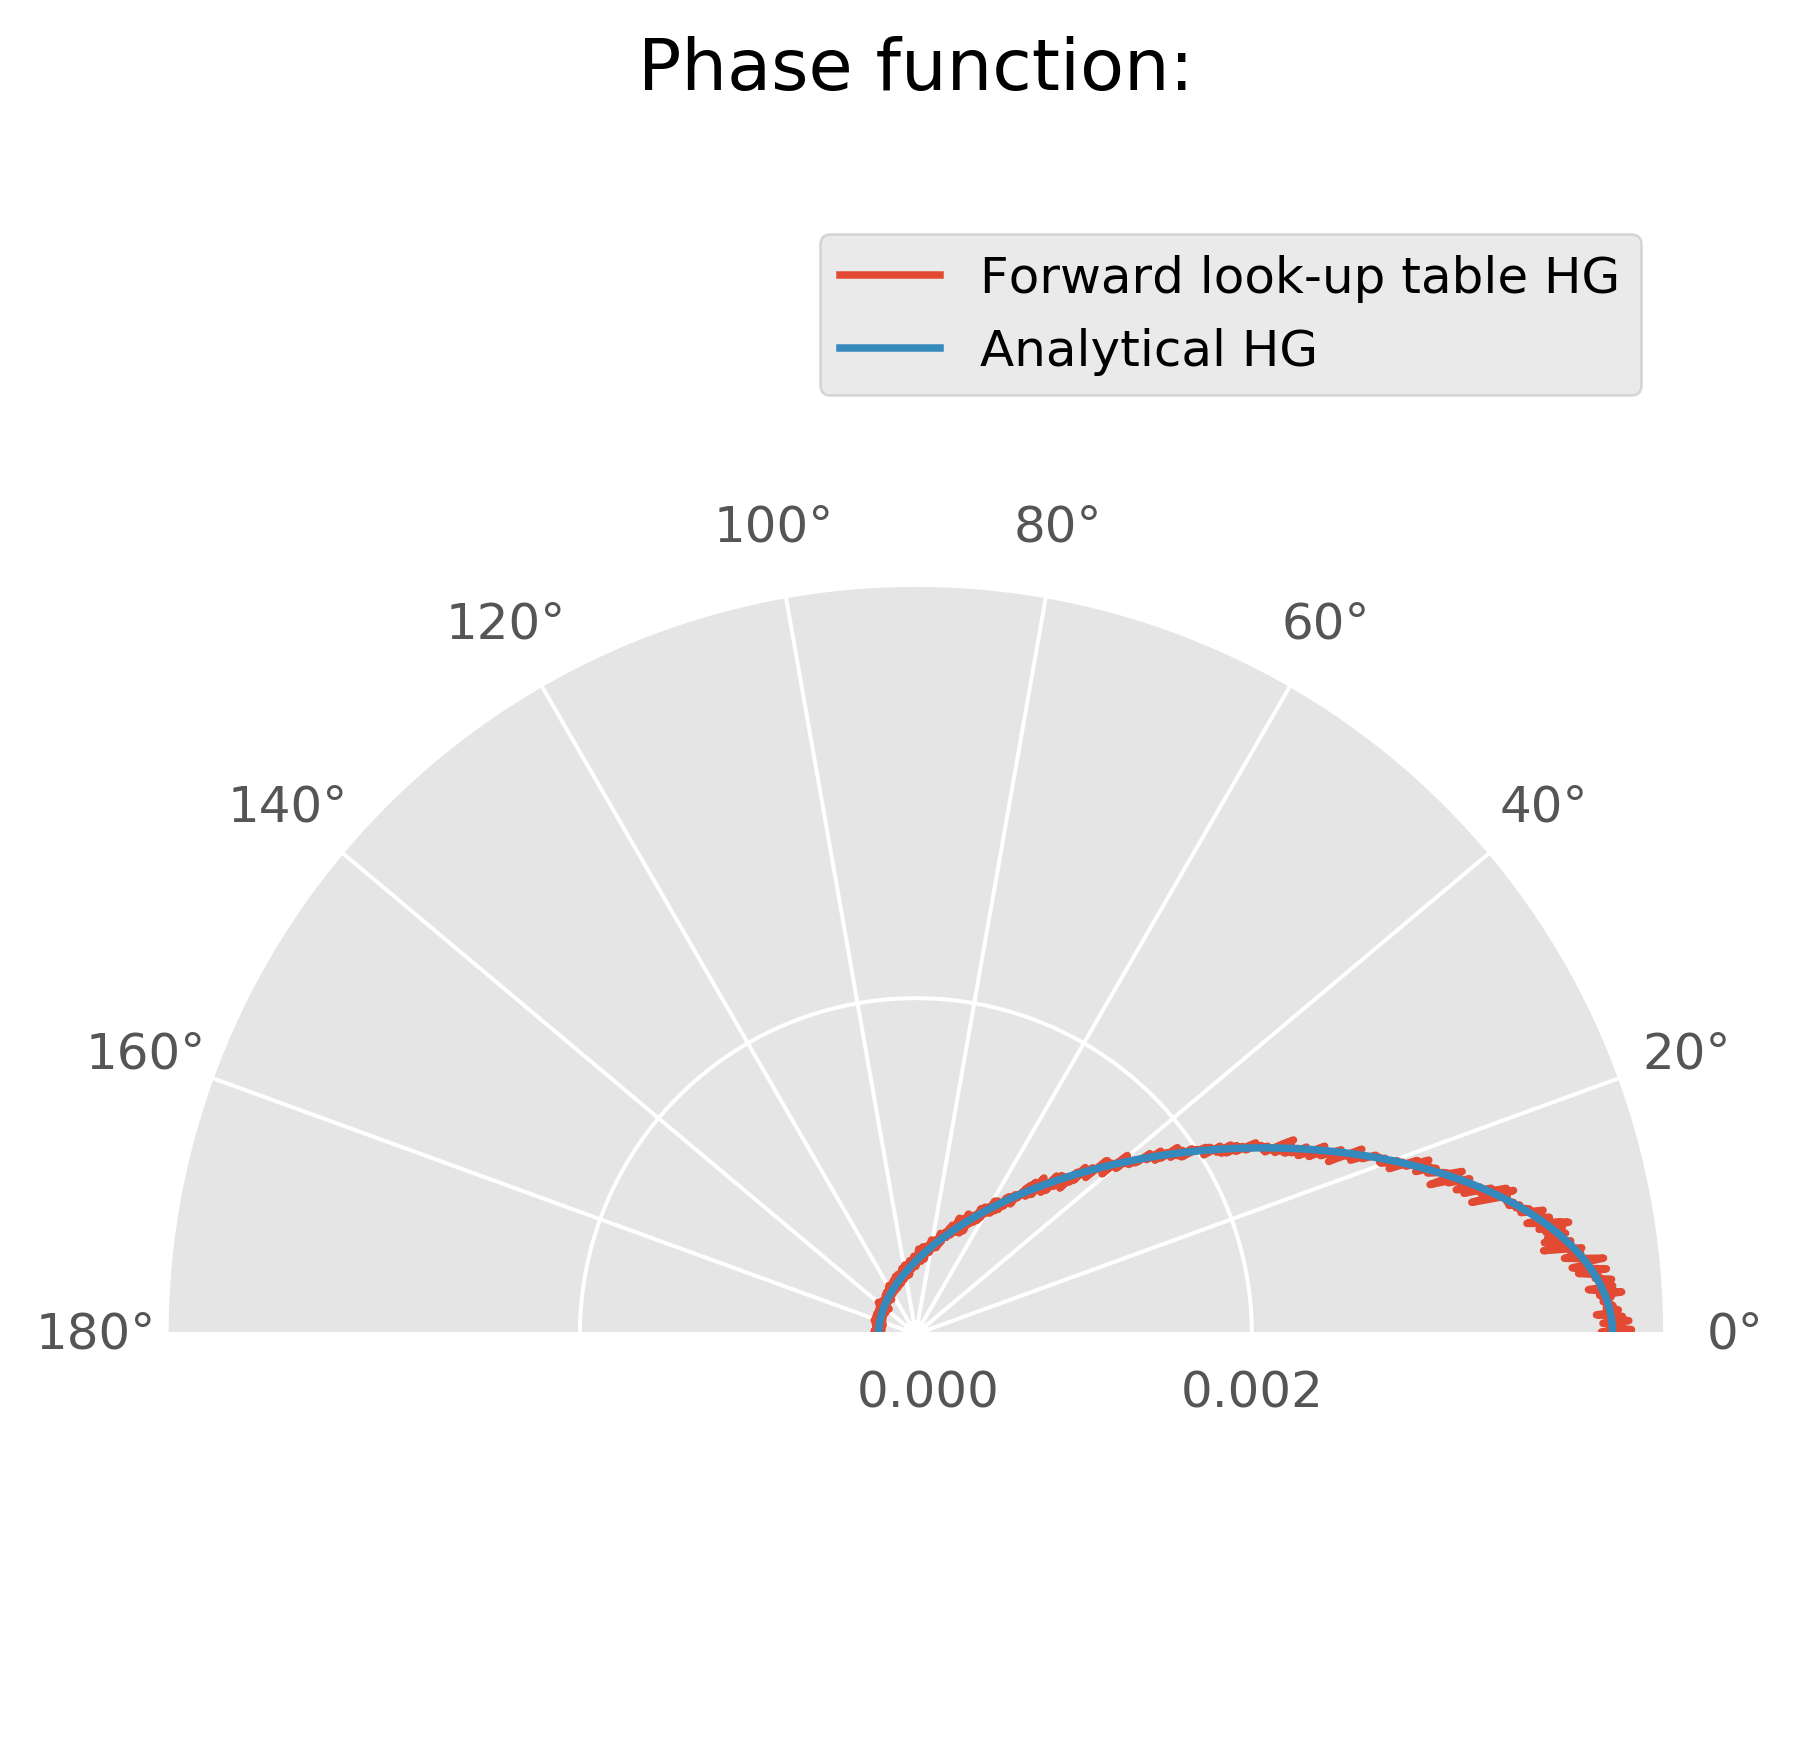

In [92]:
# Forward look-up table

lookUpTable = [np.sum(phasefunction[:i+1]) for i in range(len(phasefunction))]  #Cumulative Distribution Function

# This function uses the Forward Look-up table method to sample a cos(theta) from the phasefunction
# phasefunction has to be a properly normalized array of probabilities 
# cos_theta contains the corresponding cos(thetas)
def sampleFLT(CDF, cos_theta):
    # Unhash code to show exact position of the sampled intervals of the lookuptable
#     plt.plot(cos_theta, [0 for i in CDF], 'o')
#     plt.plot([0 for i in CDF], CDF, 'o')
#     plt.plot(cos_theta, CDF)
#     plt.show()

    zeta = np.random.random_sample()
    # Binary search for the appropriate index J
    J = bisect_left(CDF[1:], zeta)
    

#     #linear interpolation (try-except to include last interval)
    try:
        value = (cos_theta[J+1]-cos_theta[J])/(CDF[J+1] - CDF[J])*(zeta-CDF[J]) + cos_theta[J]
    except:  #CDF has one more bin as cos_theta
        value = -1 + 2*np.random.random_sample()

    return value


lookUpTable = np.insert(lookUpTable, 0, 0, axis=0)

forwardsampledPF = [sampleFLT(lookUpTable, mus) for i in range(samples)]


counts, bins, bars = plt.hist(forwardsampledPF, bins= intervals, density=True)
x = [np.arccos((bins[i]+bins[i+1])/2) for i in range(len(bins)-1)]

# Plot both the analytical and the analytically sampled phase function
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (5,5), dpi=360)

# Output has to be scaled accordingly 
# Monte Carlo output is divided by 2 due to symmetry in positive and negative angles
ax.plot(thetas, NormalizeData(counts), label = 'Forward look-up table HG')
ax.plot(thetas, NormalizeData(phasefunction), label = 'Analytical HG')

ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.set_rticks([0, np.round(np.max(NormalizeData(phasefunction)/2),3)])
ax.grid(True)
ax.set_title("Phase function:", va='bottom')
ax.set_thetamin(0)
ax.set_thetamax(180)

plt.legend()
plt.tight_layout()
plt.show()

0.0 1.0


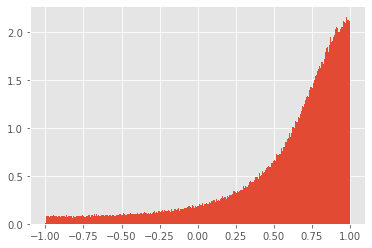

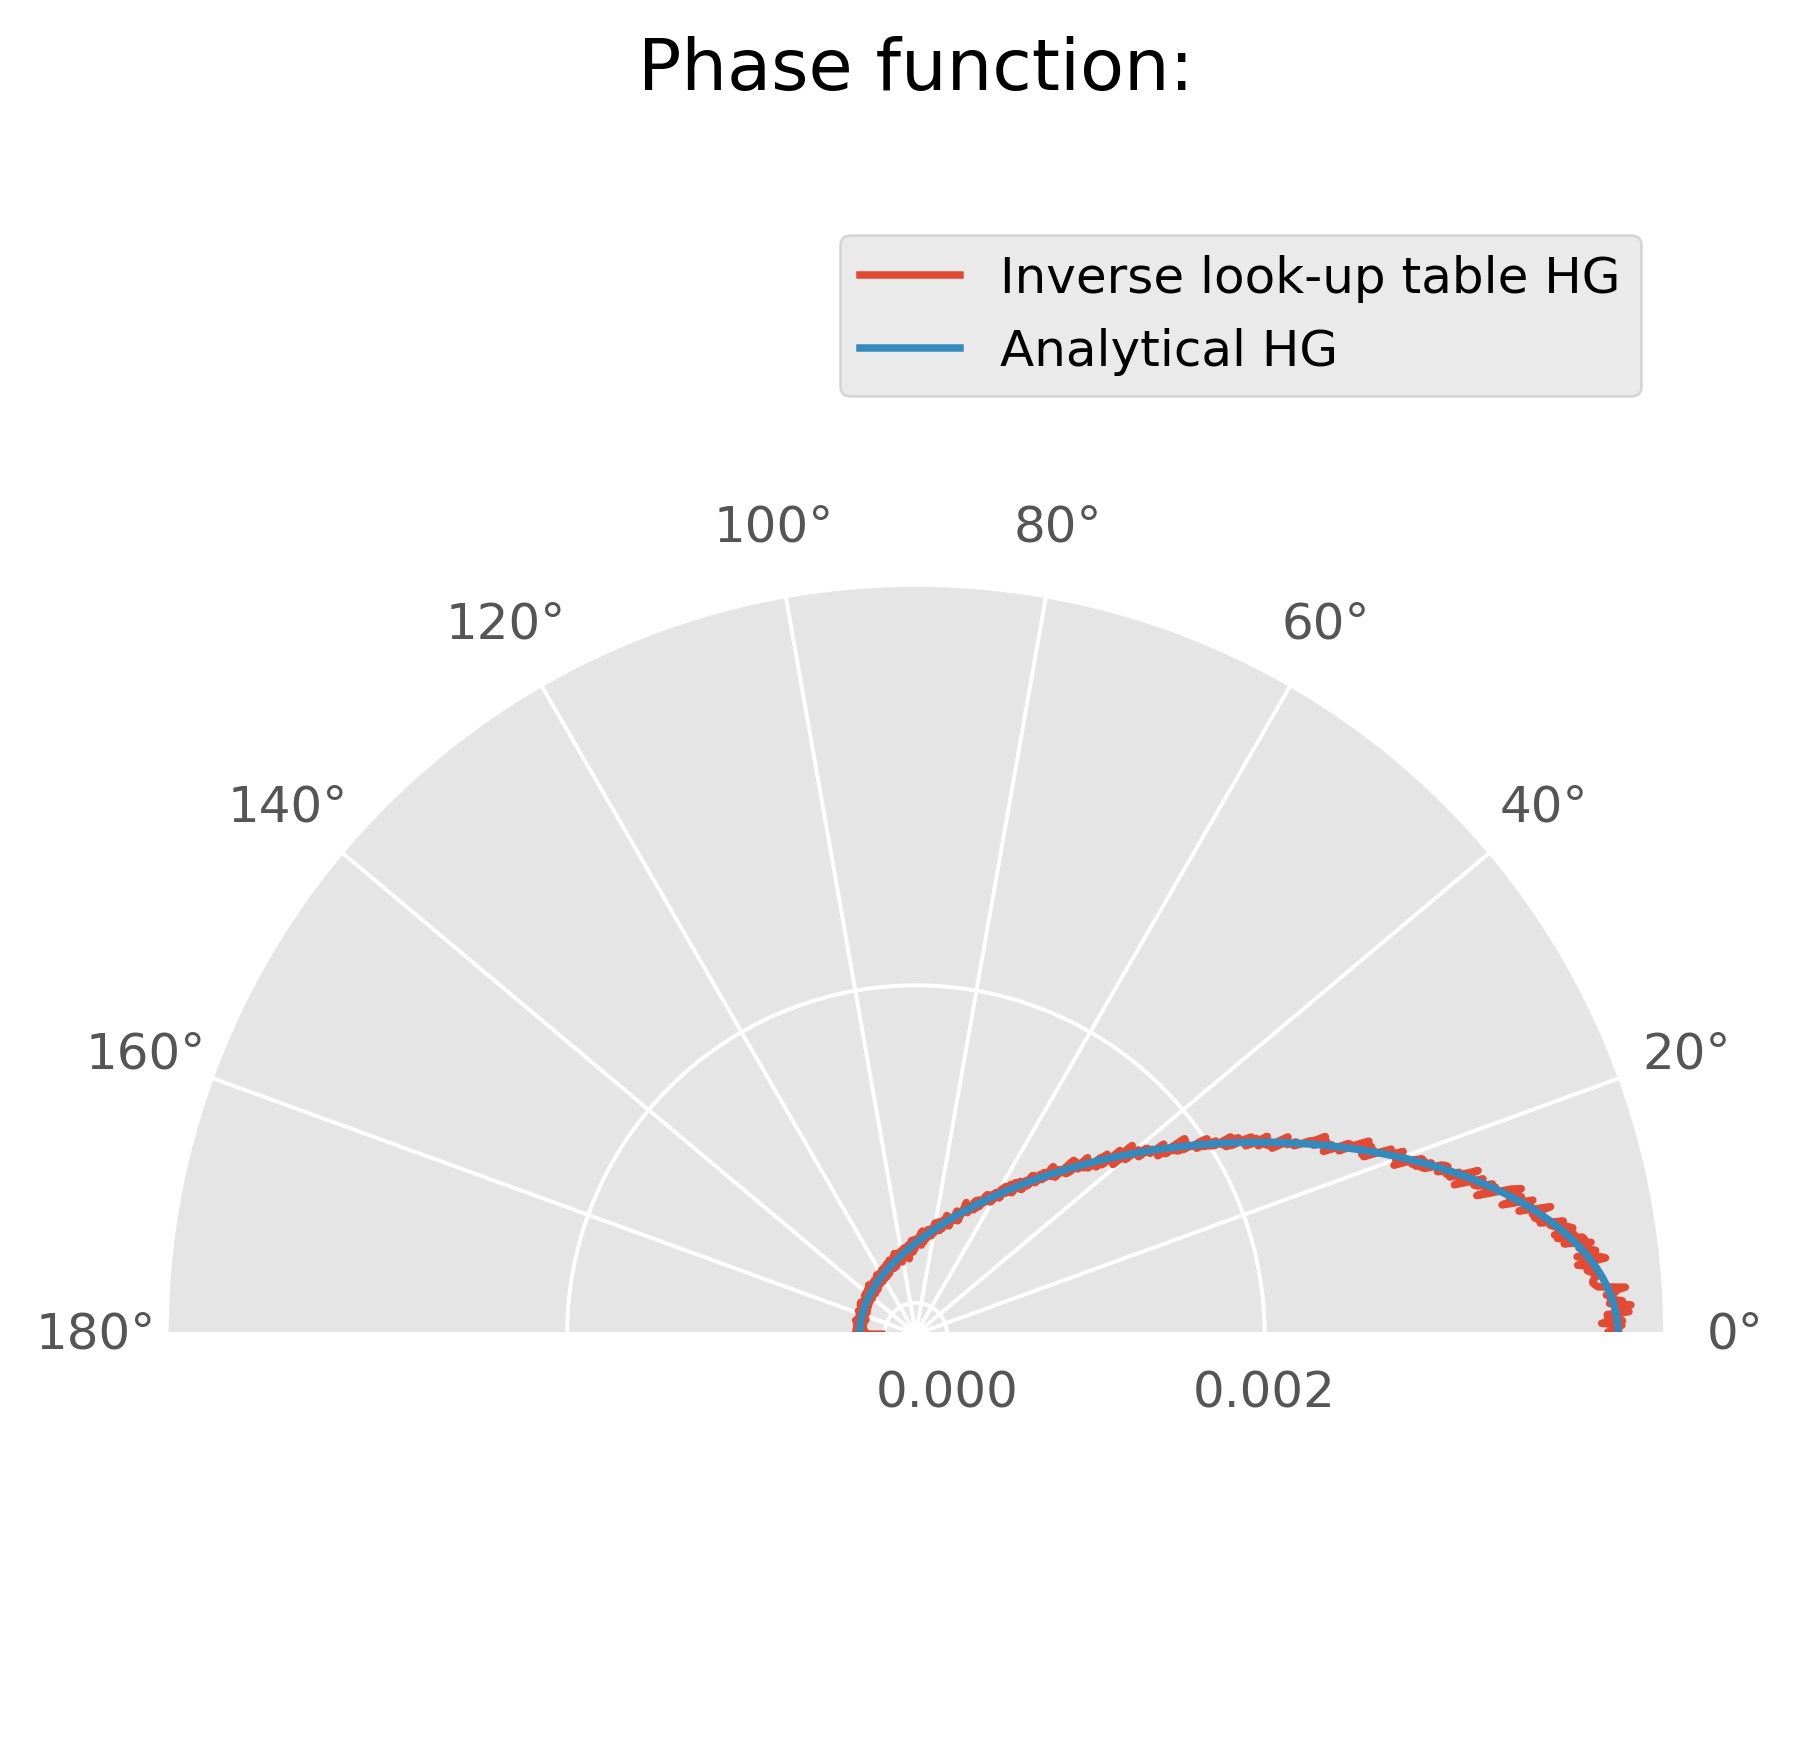

In [113]:
# Inverse look-up table

lookUpTable = [np.sum(phasefunction[:i+1]) for i in range(len(phasefunction))]  #Cumulative Distribution Function
lookUpTable = np.insert(lookUpTable, 0, 0)

# Invert and interpolate using cubic spline to retrieve relation between RV (CDF) and cos(theta) 
# cs = interp1d(lookUpTable[:-1], mus, kind = 'linear')
cs = CubicSpline(lookUpTable[:-1], mus)

print(min(lookUpTable), max(lookUpTable))

invertedLookUpTable = np.linspace(0, 1, 1000)
cos_theta_star = cs(invertedLookUpTable)/np.max(cs(invertedLookUpTable))

#this function uses the Inverted Look-up table method to sample a cos(theta) from the phasefunction
#cos_theta contains the corresponding cos(thetas)
#CDF has to be a properly normalized array of probabilities 
#ICDF contains the inverted cumulative distribution interpolated at evenly spaced points over (0,1)
def sampleILT(ICDF, cos_theta_star):
    
    zeta = np.random.random_sample()
    
    J = int(len(ICDF)*zeta)
    
    try:
        value = (cos_theta_star[J+1]-cos_theta_star[J])/(ICDF[J+1] - ICDF[J])*(zeta-ICDF[J]) + cos_theta_star[J]
    except:
        value = -1 + 2*np.random.random_sample()
    #     value = (1-cos_theta_star[J-1])/(ICDF[J] - ICDF[J-1])*(zeta-ICDF[J-1]) + cos_theta_star[J-1]
    
    return value

samples = int(1e6)


inversesampledPF = [sampleILT(invertedLookUpTable, cos_theta_star) for i in range(samples)]
x = [np.arccos((bins[i]+bins[i+1])/2) for i in range(len(bins)-1)]   #transform x-data from mu=cos(theta) to theta

counts, bins, bars = plt.hist(inversesampledPF, bins= intervals, density=True)

# Plot both the analytical and the analytically sampled phase function
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize = (5,5), dpi=360)

# Output has to be scaled accordingly 
# Monte Carlo output is divided by 2 due to symmetry in positive and negative angles
ax.plot(thetas, NormalizeData(counts), label = 'Inverse look-up table HG')
ax.plot(thetas, NormalizeData(phasefunction), label = 'Analytical HG')



# Output has to be scaled accordingly 
# Analytical result is multiplied by 2 due to symmetry in positive and negative angles
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.set_rticks([0, np.round(np.max(NormalizeData(phasefunction)/2),3)])
ax.grid(True)
ax.set_title("Phase function:", va='bottom')
ax.set_thetamin(0)
ax.set_thetamax(180)

plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# Compare complexity


import time

# samples = np.linspace(1, 100000, 101) 
# ILTlist = []

# for s in samples:
#     t0 = time.time()
#     for i in range(1,100):
#         inversesampledPF = [sampleILT(invertedLookUpTable, cos_theta_star) for i in range(int(s))]
#     t1 = time.time()
#     ILTlist.append(t1-t0)

    
# for i in range(1,1000):
#     aliasmethod = [alias_draw(J, q) for i in range(samples)]
# t2 = time.time()


repititions = 50
nsamples =int(1e5)
ITMlist = []

for i in range(repititions):
    t0 = time.time()
    [SampleHG(g) for i in range(nsamples)] 
    t1 = time.time()
    ITMlist.append(t1-t0)


FLTlist = []

for i in range(repititions):
    t0 = time.time()
    [sampleFLT(lookUpTable, mus) for i in range(nsamples)]
    t1 = time.time()
    FLTlist.append(t1-t0)

print('Klaar!')
ILTlist = []

for i in range(repititions):
    t0 = time.time()
    [sampleILT(invertedLookUpTable, cos_theta_star) for i in range(nsamples)]
    t1 = time.time()
    ILTlist.append(t1-t0)

print('Klaar!')
Aliaslist = []

# # # Construct the table.
J, q = alias_setup(phasefunction)

for i in range(repititions):
    t0 = time.time()
    [alias_draw(J, q, mus) for i in range(nsamples)]
    t1 = time.time()
    Aliaslist.append(t1-t0)


Klaar!
Klaar!


In [64]:
np.mean(ITMlist)*50*50, np.mean(ILTlist)*50*50, np.mean(FLTlist)*50*50  #potential investigation of total MCLT simulation time

(180.05895614624023, 476.38875246047974, 900.4023671150208)

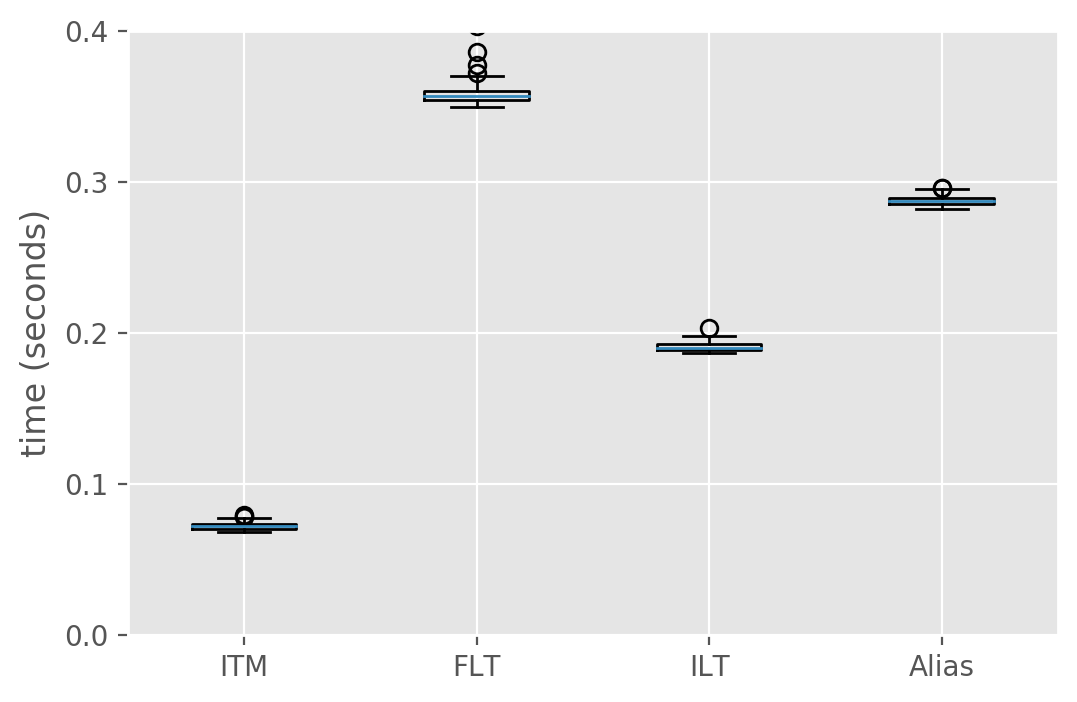

In [65]:
plt.figure(dpi=200)
plt.boxplot([ITMlist, FLTlist, ILTlist, Aliaslist], labels = ['ITM', 'FLT', 'ILT', 'Alias'], bootstrap=100)
plt.ylabel('time (seconds)')
plt.ylim(0, .4)
plt.yticks([0, .1, .2, .3, .4])
plt.savefig('/home/maarten/Code/Rijks/Generate figures for thesis/figures/results/complexityphasefunctionsampling.png')
plt.show()